In [5]:
import os
import sys
import warnings

sys.path.append("./packages/")
warnings.filterwarnings("ignore")

#import calmap
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly_express as px
from scipy.fft import fft
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from src.importation_data import load_data_txt
from src.importation_data import load_data_csv
#from Vizualizer import GeneralPresentator, PatternAnalyzer, DataPlotter
#from Processing import DataProcessor
#from FeatureEngineering import FeatureEngineer
#from FeatureSelection import filter_correlated_variables

# visualisation 
import plotly.express as px
import calplot as calmap
#!pip install --upgrade nbformat
import pandas as pd
import matplotlib.pyplot as plt
from src.calendarplot import create_year_calendar
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from src.plot_time_series import plot_validations_by_station
from src.plot_time_series import plot_vald_total_gaussian
from src.plot_time_series import plot_acf_pacf_groups

# feature engineering
from src.feature_engineering  import pipeline_feature_engineering

# modelisation
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

import shap
import xgboost
import sklearn

print(f"SHAP version: {shap.__version__}")
print(f"XGBoost version: {xgboost.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


SHAP version: 0.46.0
XGBoost version: 2.0.3
Scikit-learn version: 1.8.0


## 0. Import et mise en forme de la data

> Importation

In [6]:
from src.data_concated import df_concated
df = df_concated()
df

 52 boutiques avec ≥3888 observations


DATE   LIBELLE_ARRET  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek
1       2015-01-01           ABLON         110   2015     1     1          3
15      2015-01-01  ARCUEIL-CACHAN        1357   2015     1     1          3
16      2015-01-01      ARGENTEUIL        1556   2015     1     1          3
27      2015-01-01      AUSTERLITZ        6338   2015     1     1          3
36      2015-01-01          BALARD        1444   2015     1     1          3
...            ...             ...         ...    ...   ...   ...        ...
2813759 2025-09-30   SUCY-BONNEUIL       11336   2025     9    30          1
2813764 2025-09-30         TAVERNY        1998   2025     9    30          1
2813776 2025-09-30         TRAPPES        6257   2025     9    30          1
2813830 2025-09-30       VINCENNES       33132   2025     9    30          1
2813840 2025-09-30          YERRES        6752   2025     9    30          1

[202498 rows x 7 columns]

In [7]:
df.groupby(['LIBELLE_ARRET', 'DATE']).size().sort_values(ascending=False).head(20)


LIBELLE_ARRET  DATE      
ABLON          2015-01-01    1
NATION         2022-01-21    1
               2022-01-23    1
               2022-01-24    1
               2022-01-25    1
               2022-01-26    1
               2022-01-27    1
               2022-01-28    1
               2022-01-29    1
               2022-01-30    1
               2022-01-31    1
               2022-02-01    1
               2022-02-02    1
               2022-02-03    1
               2022-02-04    1
               2022-02-05    1
               2022-02-06    1
               2022-02-07    1
               2022-02-08    1
               2022-02-09    1
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202498 entries, 1 to 2813840
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DATE           202498 non-null  datetime64[ns]
 1   LIBELLE_ARRET  202498 non-null  object        
 2   VALD_TOTAL     202498 non-null  int32         
 3   ANNEE          202498 non-null  int32         
 4   MOIS           202498 non-null  int32         
 5   JOUR           202498 non-null  int32         
 6   dayofweek      202498 non-null  int32         
dtypes: datetime64[ns](1), int32(5), object(1)
memory usage: 8.5+ MB


## 1. Analyse des données de validation des titres IDFM

Les données utilisées dans ce projet proviennent des **stations de transport en Île-de-France**, couvrant la période de **2015 à 2025**. Elles incluent, pour chaque station et chaque jour, le nombre de validations de titres (`NB_VALD`) pour différentes catégories (`CATEGORIE_TITRE`) telles que Forfait Navigo, Imagine R, Améthyste, etc. Bien que ces données n’aient pas été associées à une problématique spécifique à l’origine, elles constituent une excellente base pour **l’analyse de séries temporelles et la prévision de fréquentation** dans le réseau de transport francilien.  

### Problématiques possibles

Trois types d’analyses peuvent être envisagés sur ce dataset :  

1. **Prédire le nombre total de validations par station et par jour**  
2. **Identifier les périodes de forte affluence pour optimiser la gestion du réseau**  

L’objectif principal est **d’anticiper la fréquentation du réseau** pour améliorer la planification des ressources (train/métro/bus), réduire les engorgements, et adapter l’offre aux besoins réels des voyageurs.  

### Notes sur les données
#### Variables
La base de données brute est composée des variables suivantes :  
- `DATE` : La date de validation (au format yyyy-mm-dd)  
- `CODE_STIF_ARRET` : Identifiant unique de la station  
- `CODE_STIF_TRNS` : Identifiant du réseau ou de la ligne  
- `LIBELLE_ARRET` : Nom de la station  
- `CATEGORIE_TITRE` : Type de titre validé (Forfait Navigo, Imagine R, Améthyste, etc.)  
- `NB_VALD` : Nombre de validations pour cette catégorie de titre et cette station à la date donnée (certaines valeurs initialement textuelles, ex. `"Moins de 5"`, ont été transformées en numériques)  
- `VALD_TOTAL` : Somme des validations pour toutes les catégories de titres pour la station à la date donnée  
Certaines colonnes, comme `NB_VALD`, peuvent contenir des valeurs textuelles (`"Moins de 5"`) qui nécessitent un **nettoyage préalable** avant la conversion en valeurs numériques. Après nettoyage, nous obtenons des séries temporelles fiables pour chaque station et chaque type de titre.  

Nous avons également créé une **colonne `VALD_TOTAL`** correspondant à la somme des validations par station et par jour, afin de disposer d’une métrique agrégée sur laquelle baser les analyses.  

### Horizon temporel et granularité

- **Granularité** : journalière (`t` = 1 jour), avec possibilité d’agrégation mensuelle ou annuelle pour certaines analyses.  
- **Horizon** : la prédiction peut se faire pour le jour suivant ou pour les périodes de pointe à l’intérieur de la journée, selon la problématique (optimisation des trains/métros aux heures de forte affluence).  

### Conclusion

- **Cible principale** : `VALD_TOTAL` (nombre total de validations par station et par jour)  
- **Objectif** : prévoir la fréquentation pour optimiser le réseau, éviter la surcharge et adapter la capacité des trains/bus.  
- **Approche** : analyse de séries temporelles, détection de saisonnalités et tendances, prévision à court terme.

In [9]:
df.isnull().sum()

DATE             0
LIBELLE_ARRET    0
VALD_TOTAL       0
ANNEE            0
MOIS             0
JOUR             0
dayofweek        0
dtype: int64

In [10]:
liste_gares = df["LIBELLE_ARRET"].unique().tolist()
print(len(liste_gares))
liste_gares[1:10]

52


['ARCUEIL-CACHAN',
 'ARGENTEUIL',
 'AUSTERLITZ',
 'BALARD',
 'BASTILLE',
 'BELLEVILLE',
 'BERCY',
 'BIBLIOTHEQUE FRANCOIS MITTERRAND',
 'BOURG-LA-REINE']

## 2. Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

In [11]:
import plotly.express as px

fig = px.treemap(
    df,
    path=["ANNEE", "MOIS", "JOUR"],
    values="VALD_TOTAL",
    color="VALD_TOTAL",
    color_continuous_scale="Viridis",
    title="Treemap des validations par année, mois et jour"
)

fig.show()

In [12]:
df.head(2)

DATE   LIBELLE_ARRET  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek
1  2015-01-01           ABLON         110   2015     1     1          3
15 2015-01-01  ARCUEIL-CACHAN        1357   2015     1     1          3

In [13]:
df["VALD_TOTAL"].describe()

count    202498.000000
mean      18173.713005
std       28782.359053
min           1.000000
25%        4044.000000
50%        9242.500000
75%       18167.000000
max      558868.000000
Name: VALD_TOTAL, dtype: float64

In [14]:
df.groupby("ANNEE")["VALD_TOTAL"].describe()

count          mean           std  min      25%      50%       75%  \
ANNEE                                                                         
2015   18893.0  16787.927751  22489.190588  2.0  3797.00   9233.0  18693.00   
2016   18955.0  17764.390979  23940.160729  2.0  4195.00   9676.0  18956.50   
2017   18978.0  18496.812256  24504.602271  2.0  4475.25  10297.0  19513.00   
2018   18967.0  18397.621975  24234.921761  5.0  4297.00  10426.0  19793.50   
2019   18945.0  19724.180417  30049.625375  5.0  4297.00  10477.0  20266.00   
2020   19004.0  11471.225900  23143.614732  5.0  1465.50   4628.5  10698.00   
2021   18977.0  14742.229014  24785.481734  5.0  3367.00   7121.0  14057.00   
2022   18978.0  18663.435293  29665.360389  5.0  4601.00   9429.5  17512.50   
2023   18978.0  19368.773475  31850.404688  1.0  4706.25   9771.0  17770.00   
2024   17628.0  22609.541071  38462.767555  1.0  5226.00  10893.0  20607.75   
2025   14195.0  23563.838253  39256.692604  1.0  5485.00  11166.0  20306.50   

            max  
ANNEE            
2015   148247.0  
2016   135620.0  
2017   148980.0  
2018   136890.0  
2019   304452.0  
2020   259328.0  
2021   234708.0  
2022   255589.0  
2023   281768.0  
2024   558868.0  
2025   293138.0

In [15]:
top5_frequentation = df.groupby('LIBELLE_ARRET')['VALD_TOTAL'].describe().sort_values(by='mean', ascending=False).head()
top5_frequentation

count           mean           std    min      25%       50%  \
LIBELLE_ARRET                                                                  
SAINT-LAZARE   3895.0  135153.839538  70643.839714    2.0  90411.0  120625.0   
GARE DE LYON   3899.0   88706.561682  34855.291962   74.0  60049.0   94590.0   
MONTPARNASSE   3899.0   75364.458323  31312.697063  213.0  51295.5   80304.0   
GARE DU NORD   3899.0   74022.179020  26285.701009   26.0  54110.0   76553.0   
GARE DE L'EST  3899.0   67460.389844  27398.526516   25.0  44591.0   73171.0   

                    75%       max  
LIBELLE_ARRET                      
SAINT-LAZARE   185551.0  558868.0  
GARE DE LYON   113276.5  267201.0  
MONTPARNASSE    98882.5  228916.0  
GARE DU NORD    95458.5  202271.0  
GARE DE L'EST   88298.5  200519.0

In [16]:
bottom_frequentation = df.groupby('LIBELLE_ARRET')['VALD_TOTAL'].describe().sort_values(by='mean', ascending=False).tail()
bottom_frequentation

count         mean          std  min      25%     50%  \
LIBELLE_ARRET                                                           
ETAMPES        3899.0  2525.814311  1305.041377  1.0  1300.50  2620.0   
DOMONT         3898.0  2156.994356  1426.879113  2.0   858.00  2077.5   
PUTEAUX        3889.0  2020.917717  1186.748011  5.0  1011.00  1922.0   
ABLON          3898.0  1117.875834   598.026697  2.0   637.00  1158.0   
TAVERNY        3888.0   946.048354   481.804227  1.0   536.75   945.5   

                   75%     max  
LIBELLE_ARRET                   
ETAMPES        3648.50  5888.0  
DOMONT         3545.75  8137.0  
PUTEAUX        2990.00  7836.0  
ABLON          1568.75  3975.0  
TAVERNY        1370.25  3199.0

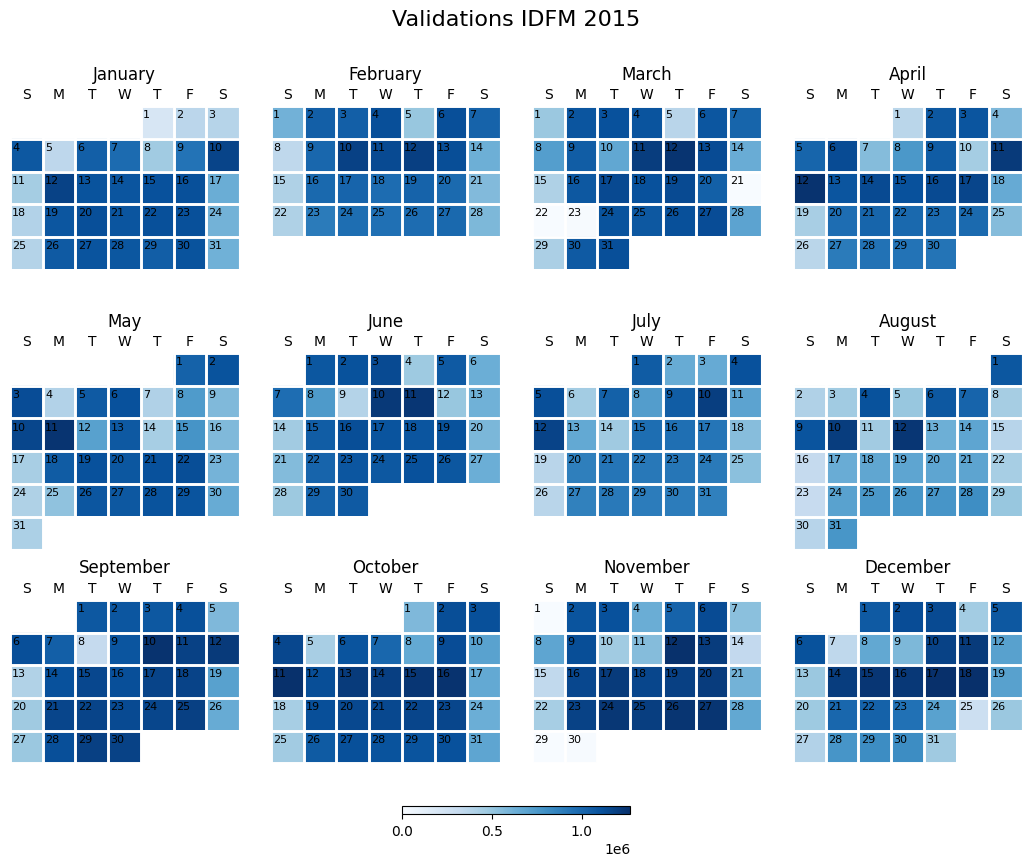

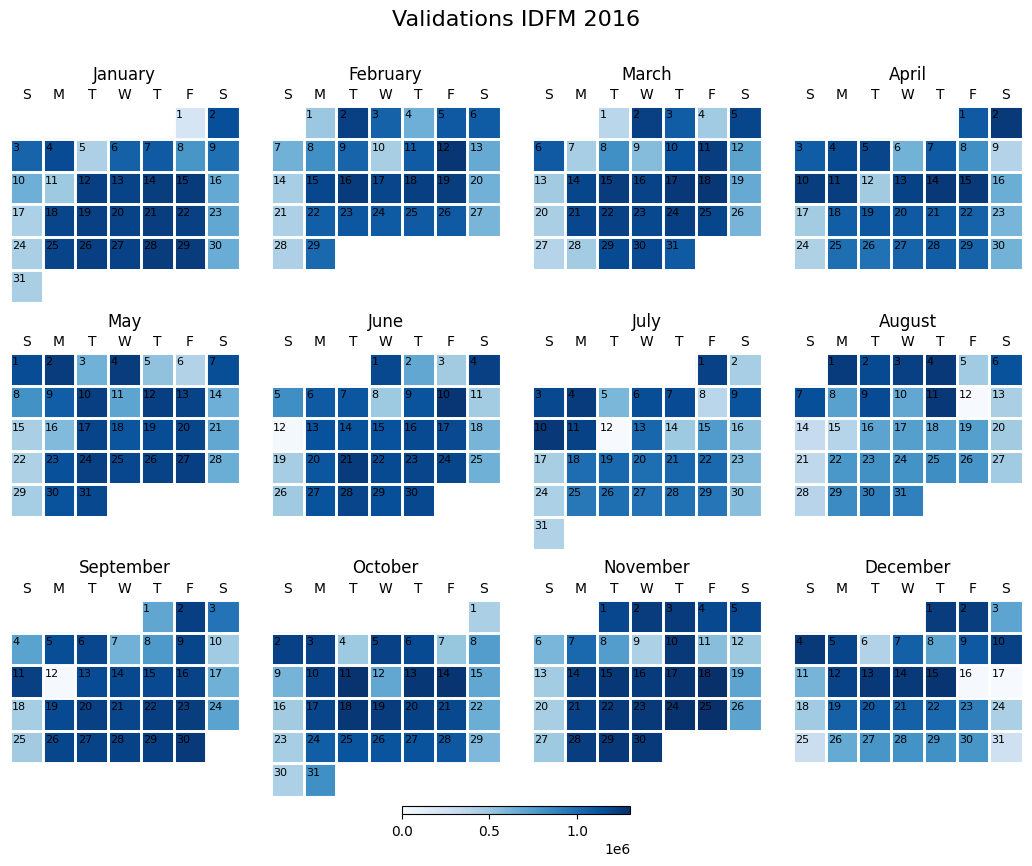

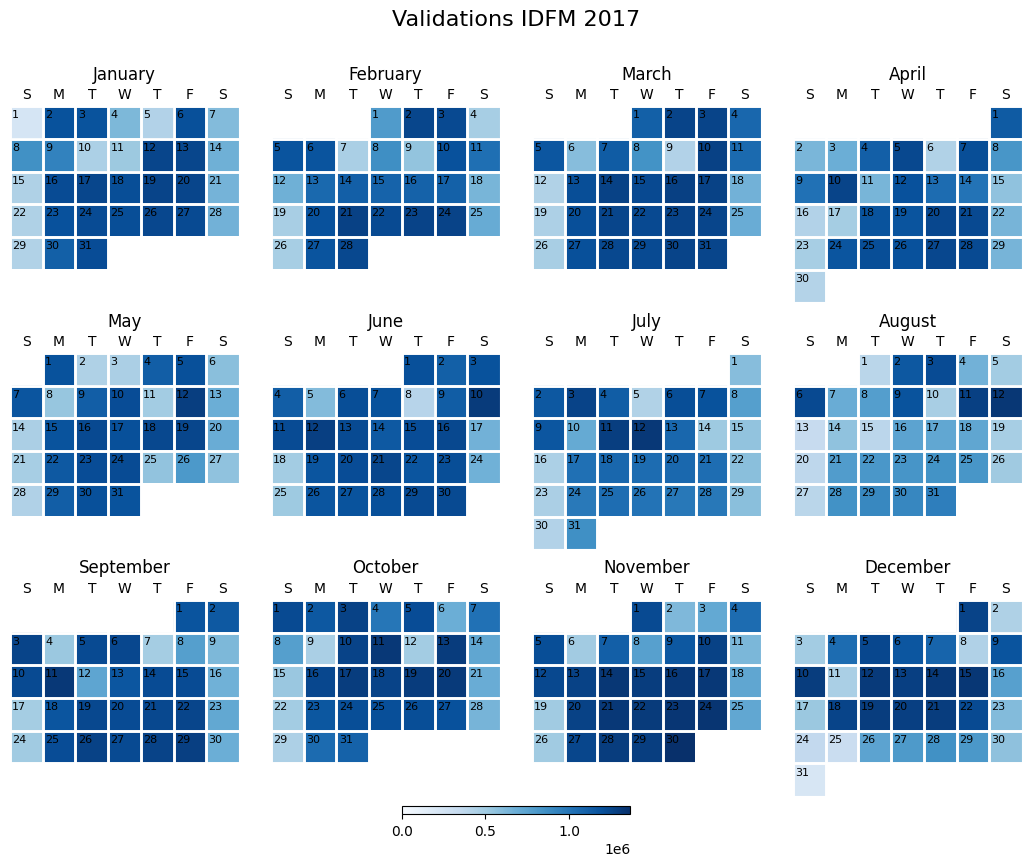

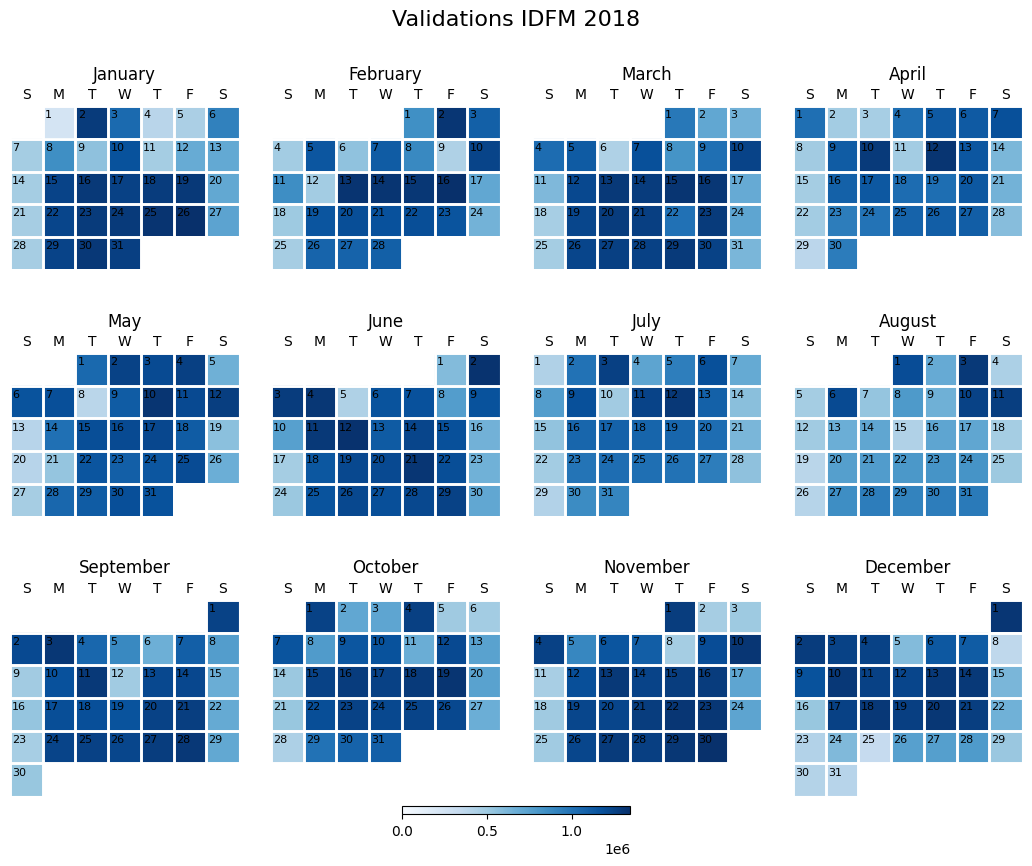

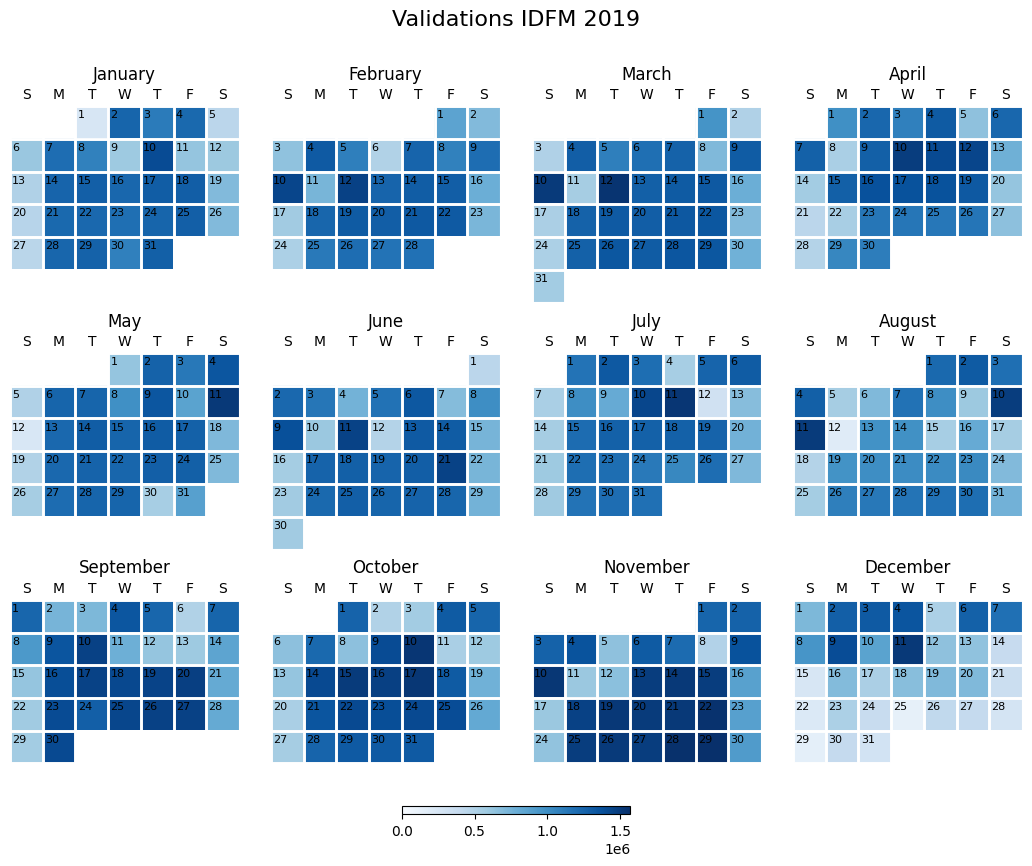

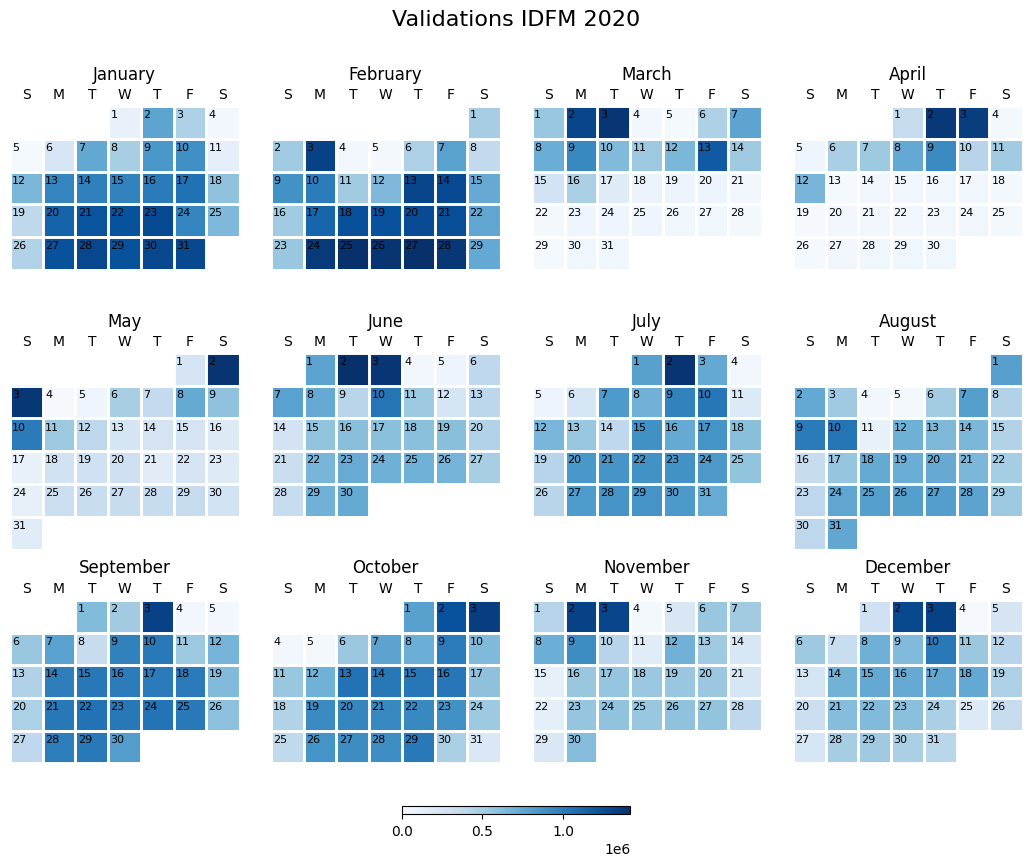

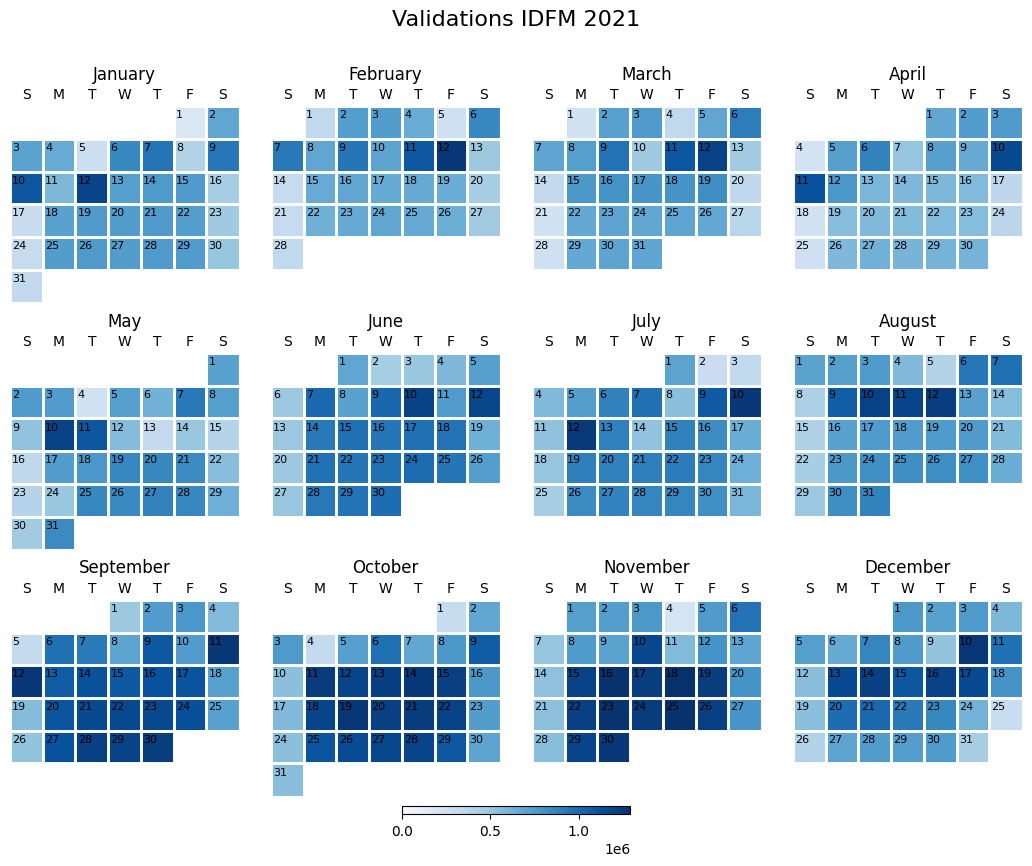

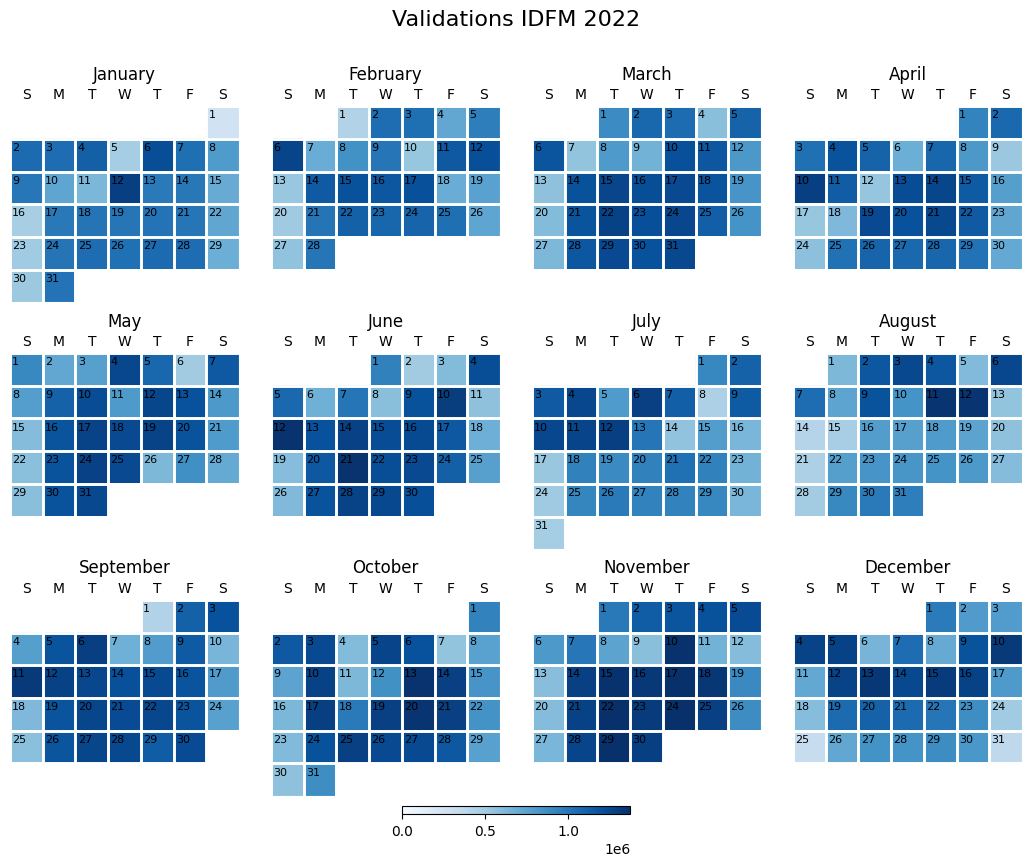

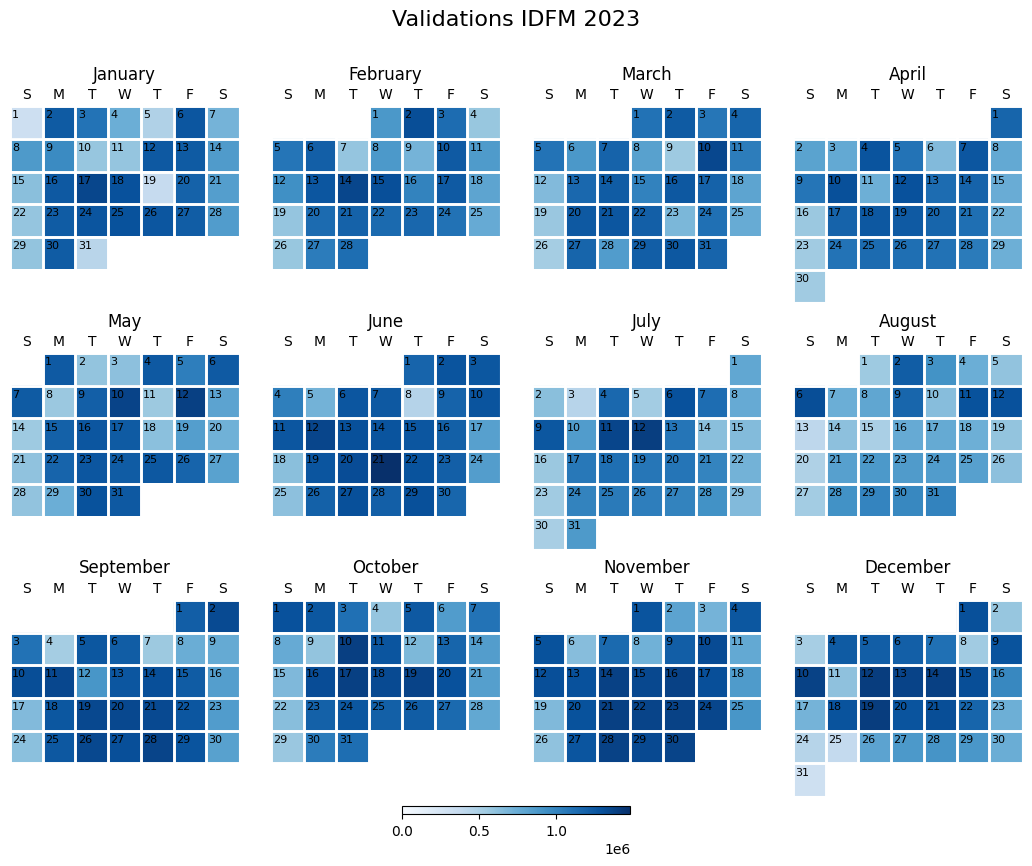

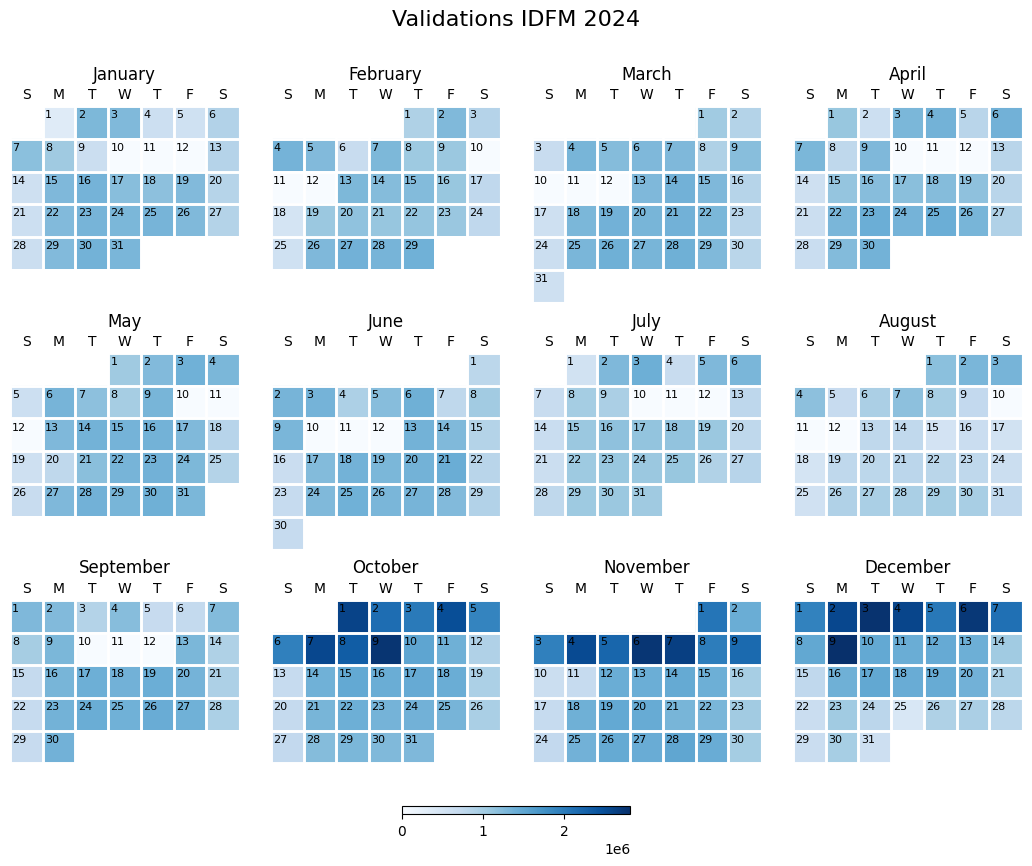

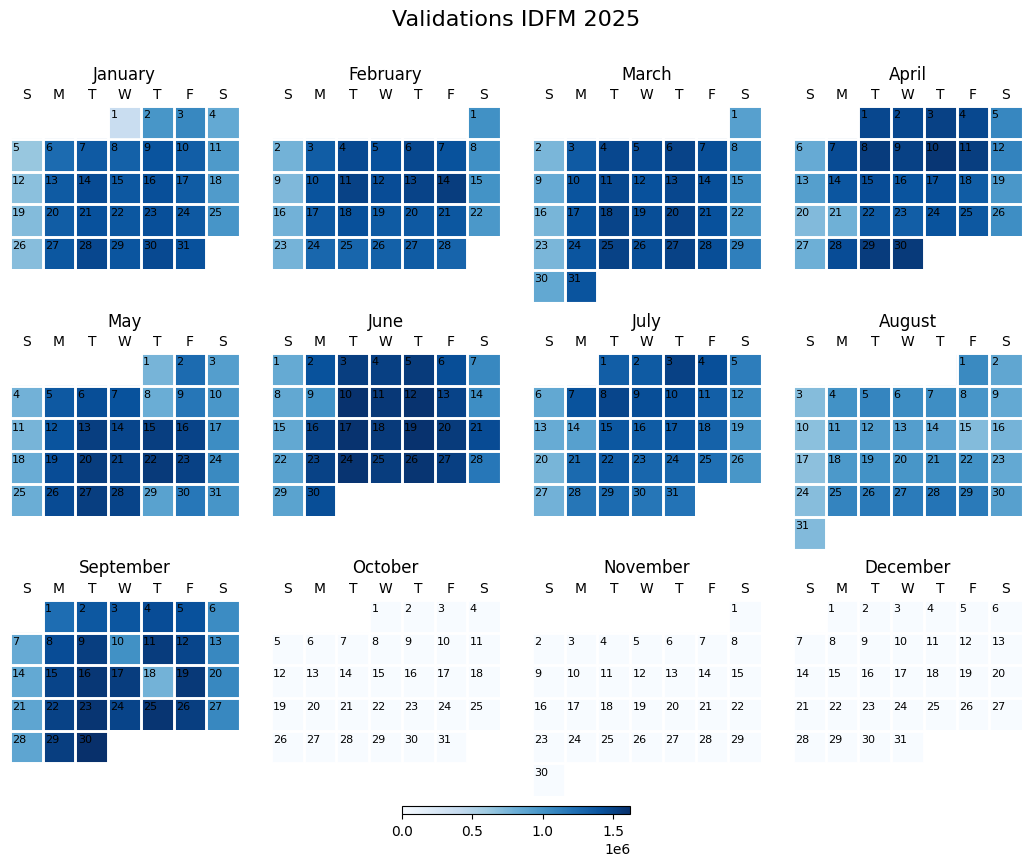

In [17]:
daily_total = df.groupby('DATE')['VALD_TOTAL'].sum()

vmin = daily_total.min()
vmax = daily_total.max()


cmap = "viridis"
for year in range(2015, 2026):
    series_year = daily_total[daily_total.index.year == year]

    hlmap = {}

    # Générer le calendrier
    create_year_calendar(series_year, 
                         year, 
                         title=f'Validations IDFM {year}', 
                         filename=f'calendar_{year}.png',
                         cmap='Blues',
                         hlmap=hlmap,
                         showcb=True)


In [18]:
fig = plot_validations_by_station(
                                  df, 
                                  stations=top5_frequentation.reset_index()["LIBELLE_ARRET"].tolist(), 
                                  start_year=2015, 
                                  end_year=2015,
                                  freq='D'
                        
                                  )

# Plot des validations des boutiques avec beaucoup de frequentation

In [19]:
fig = plot_validations_by_station(
                                  df, 
                                  stations=bottom_frequentation.reset_index()["LIBELLE_ARRET"].tolist(), 
                                  start_year=2015, 
                                  end_year=2025
                                  )

# Plot des validations des boutiques avec peu de frequentation

In [20]:
plot_validations_by_station(df, 
                            stations=bottom_frequentation.reset_index()["LIBELLE_ARRET"].tolist(),
                            start_year=2015, 
                            end_year=2015, 
                            freq='W')

# Plot des validations des boutiques avec peu de frequentation par semaine

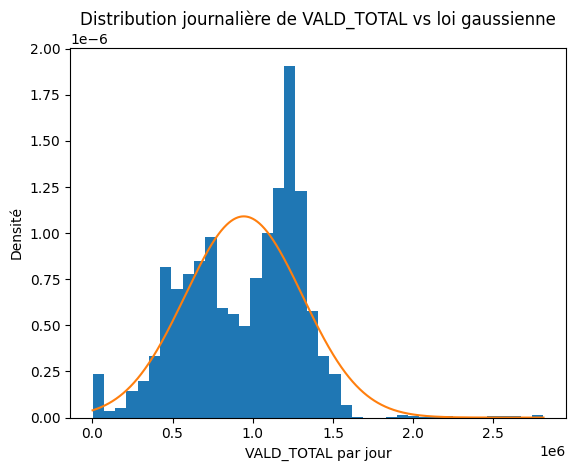

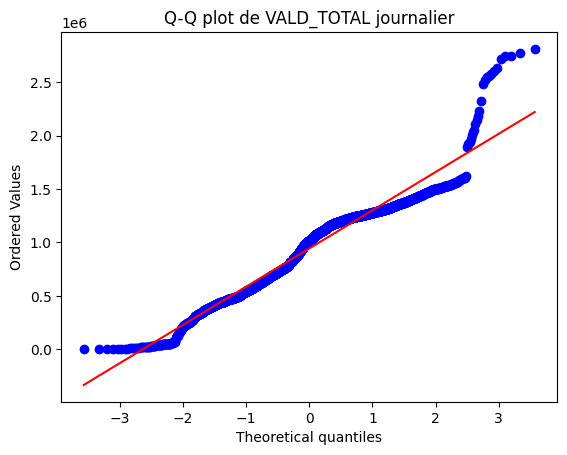

{'mean': 943867.7958450884, 'std': 365635.3370207746, 'nb_days': 3899}

In [21]:
plot_vald_total_gaussian(
    df,
    date_col='DATE',
    value_col='VALD_TOTAL',
    bins=40
)

# Plot de la distribution des validations totales avec une courbe gaussienne

## Features Engeneering 

In [22]:
df= pipeline_feature_engineering(df, date_col="DATE")
df.sample(5)

DATE  LIBELLE_ARRET  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek  \
167507  2015-08-26      INVALIDES        7516   2015     8    26          2   
1168438 2019-06-23  PORTE MAILLOT       14261   2019     6    23          6   
1392505 2020-05-18        NOISIEL        2325   2020     5    18          0   
1584969 2021-02-18   GARE DU NORD       50488   2021     2    18          3   
2680259 2025-04-08  PORTE MAILLOT       18993   2025     4     8          1   

         is_holiday holiday_name  is_school_holiday  ...  is_autumn  \
167507        False          NaN              False  ...      False   
1168438       False          NaN              False  ...      False   
1392505       False          NaN              False  ...      False   
1584969       False          NaN               True  ...      False   
2680259       False          NaN              False  ...      False   

         is_lockdown  weekend_school_holiday  weekend_holiday  dayofweek_sin  \
167507         False                   False            False       0.974928   
1168438        False                   False            False      -0.781831   
1392505        False                   False            False       0.000000   
1584969        False                   False            False       0.433884   
2680259        False                   False            False       0.781831   

         dayofweek_cos  dayofmonth_sin  dayofmonth_cos     month_sin  \
167507       -0.222521       -0.937752        0.347305 -8.660254e-01   
1168438       0.623490       -0.968077       -0.250653  1.224647e-16   
1392505       1.000000       -0.299363       -0.954139  5.000000e-01   
1584969      -0.900969       -0.299363       -0.954139  8.660254e-01   
2680259       0.623490        0.988468        0.151428  8.660254e-01   

         month_cos  
167507   -0.500000  
1168438  -1.000000  
1392505  -0.866025  
1584969   0.500000  
2680259  -0.500000  

[5 rows x 24 columns]

In [23]:
import pickle

with open("df_final.pkl", "wb") as f:
    pickle.dump(df, f)

# save the df

In [24]:
#with open("df_final.pkl", "rb") as f:
#    df = pickle.load(f)


In [25]:
pd.set_option('display.max_columns', None)


df_copy = df.copy()
print(df_copy.shape)
df_copy.head(2)

(202498, 24)


DATE   LIBELLE_ARRET  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek  \
1  2015-01-01           ABLON         110   2015     1     1          3   
15 2015-01-01  ARCUEIL-CACHAN        1357   2015     1     1          3   

    is_holiday holiday_name  is_school_holiday  is_weekend  is_winter  \
1         True  1er janvier              False       False       True   
15        True  1er janvier              False       False       True   

    is_spring  is_summer  is_autumn  is_lockdown  weekend_school_holiday  \
1       False      False      False        False                   False   
15      False      False      False        False                   False   

    weekend_holiday  dayofweek_sin  dayofweek_cos  dayofmonth_sin  \
1             False       0.433884      -0.900969             0.0   
15            False       0.433884      -0.900969             0.0   

    dayofmonth_cos  month_sin  month_cos  
1              1.0        0.5   0.866025  
15             1.0        0.5   0.866025

### 6.1 ACF, PACF

⚠️ Station inconnue : CHATELET-LES HALLES


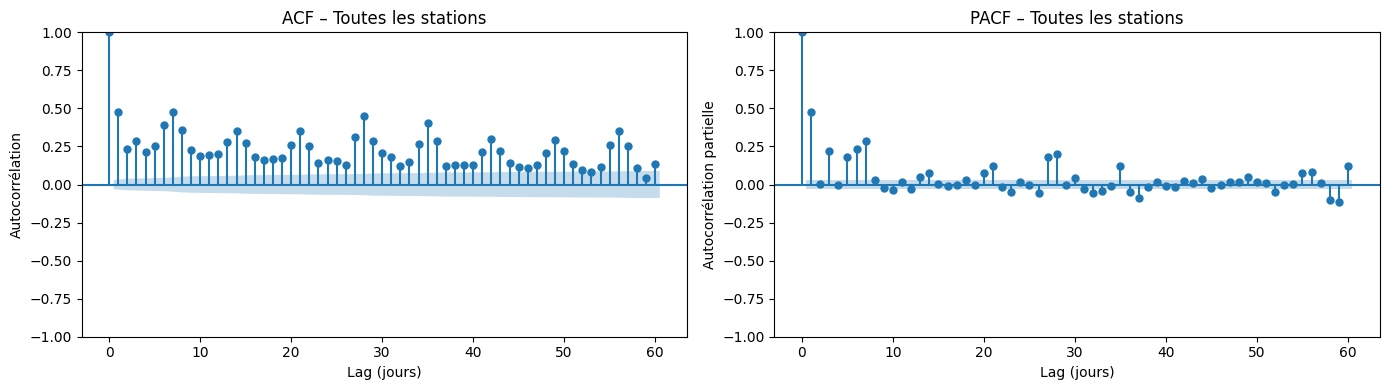

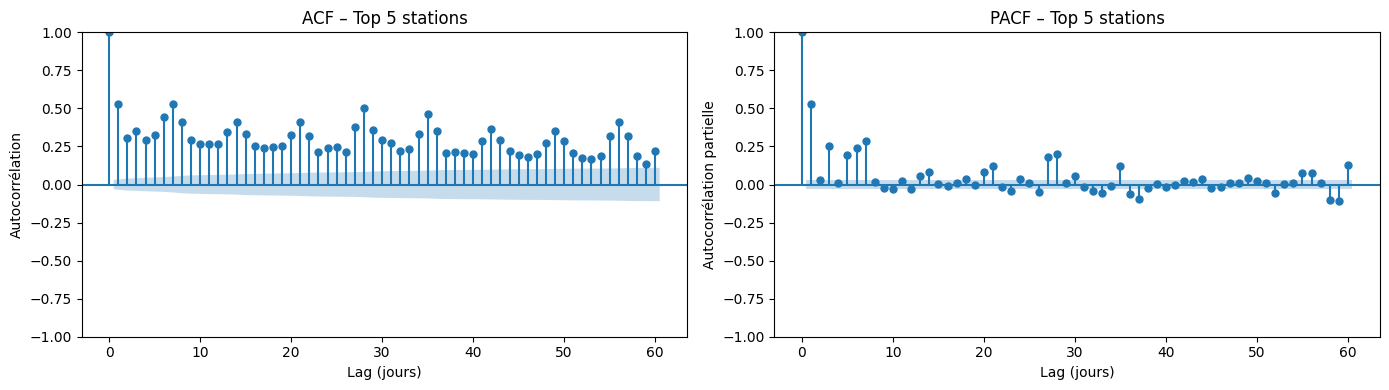

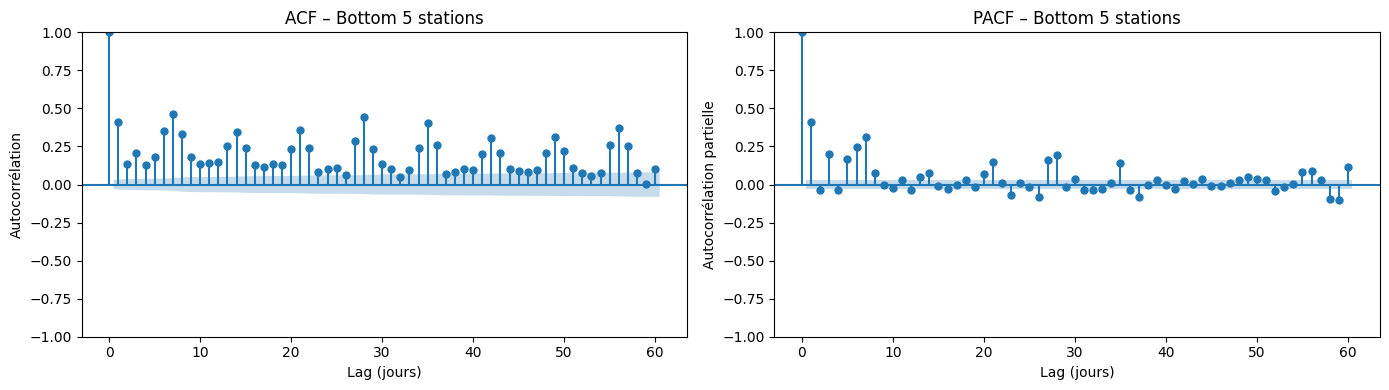

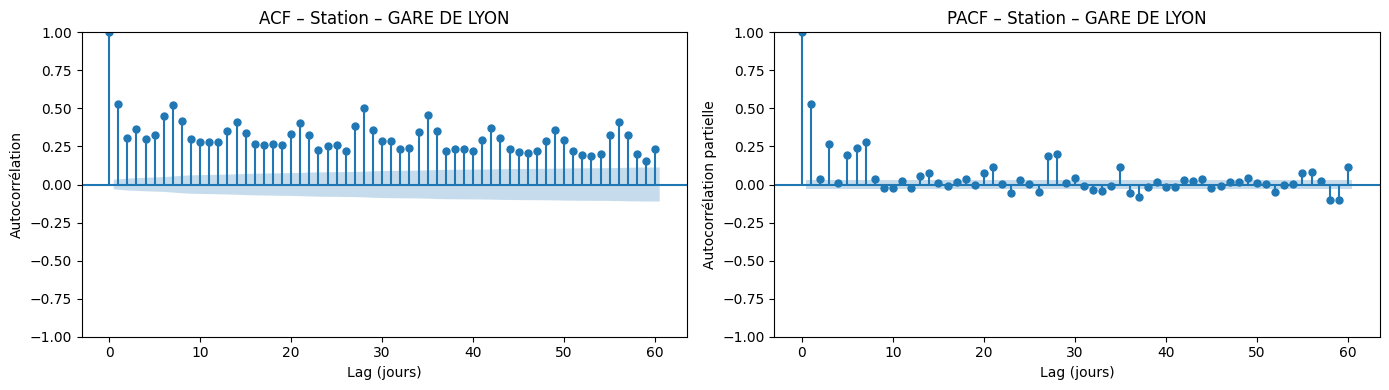

In [26]:
plot_acf_pacf_groups(
    df_copy,
    stations=["GARE DE LYON", "CHATELET-LES HALLES"]
)

# Plot de l'ACF et PACF des series 

## 7. SkForecast 

In [27]:
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import (
    RollingFeatures,
    reshape_series_long_to_dict,
    reshape_exog_long_to_dict,
    reshape_series_exog_dict_to_long
)

In [28]:
df_copy = df_copy.sort_values(by=['LIBELLE_ARRET', 'DATE']).copy()

series = df_copy[["LIBELLE_ARRET", "DATE", "VALD_TOTAL"]]
exog = df_copy.drop(columns=['VALD_TOTAL', "holiday_name"])

In [29]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = reshape_series_long_to_dict(
    data      = series,
    series_id = 'LIBELLE_ARRET',
    index     = 'DATE',
    values    = 'VALD_TOTAL',
    freq      = 'D',
    suppress_warnings=True
)

exog_dict = reshape_exog_long_to_dict(
    data      = exog,
    series_id = 'LIBELLE_ARRET',
    index     = 'DATE',
    freq      = 'D',
    suppress_warnings=True,
    consolidate_dtypes=False
)

In [30]:
cat_cols = ['dayofweek', 'MOIS', 'ANNEE', 'JOUR']

for col in cat_cols:
    # récupérer toutes les catégories présentes dans toutes les séries
    all_cats = pd.Index([])
    for k in exog_dict.values():
        if col in k.columns:
            all_cats = all_cats.union(k[col].astype('category').cat.categories)
    
    # uniformiser toutes les séries
    for gare, m in exog_dict.items():
        if col in m.columns:
            m[col] = pd.Categorical(m[col], categories=all_cats)
            exog_dict[gare] = m


In [31]:
# Colonnes bool / object à convertir
bool_cols = ['is_holiday', 'is_school_holiday', 'is_weekend',
             'is_winter', 'is_spring', 'is_summer', 'is_autumn',
             'is_lockdown', 'weekend_school_holiday', 'weekend_holiday']

for col in bool_cols:
    for gare, h in exog_dict.items():
        if col in h.columns:
            h[col] = h[col].fillna(False).astype(bool)
            exog_dict[gare] = h


In [32]:
end_train = "2025-08-31"
series_dict_train = {k: v. loc[:end_train,] for k, v in series_dict.items()}
exog_dict_train = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
exog_dict_test = {k: v.loc[end_train :,] for k, v in exog_dict.items()}

In [33]:
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore'),
                          make_column_selector(dtype_exclude=np.number)
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [34]:
# Fit forecaster
# ==============================================================================
estimator = XGBRegressor(
    n_estimators=800,
    enable_categorical=True, 
    max_depth=7, 
    subsample=0.7, 
    colsample_bytree=1, 
    max_features=0.5, 
    random_state=42, 
    bootstrap=True,  
    n_jobs=-1,
    learning_rate=0.01,
    min_child_weight=5 
    )



window_features =RollingFeatures(
    stats=['mean', 'mean', "mean", "std", "std"], 
    window_sizes=[3, 7, 14, 7, 14]
    )

exog_features = ["ANNEE", "MOIS", "JOUR", "dayofweek"]

forecaster = ForecasterRecursiveMultiSeries(
                estimator          = estimator,
                lags               = [1, 2, 3, 7, 14, 21, 28, 35, 42, 49, 56, 245, 252, 259, 336, 343, 350, 357, 364],
                window_features    = window_features,
                encoding           = "ordinal",
                dropna_from_series = True,
                transformer_exog=one_hot_encoder
            )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Estimator: XGBRegressor 
Lags: [  1   2   3   7  14  21  28  35  42  49  56 245 252 259 336 343 350 357
 364] 
Window features: ['roll_mean_3', 'roll_mean_7', 'roll_mean_14', 'roll_std_7', 'roll_std_14'] 
Window size: 364 
Series encoding: ordinal 
Series names (levels): 
    ABLON, ARCUEIL-CACHAN, ARGENTEUIL, AUSTERLITZ, BALARD, BASTILLE, BELLEVILLE,
    BERCY, BIBLIOTHEQUE FRANCOIS MITTERRAND, BOURG-LA-REINE, BRETIGNY, BRUNOY,
    BRY-SUR-MARNE, CHAMPIGNY, CHATOU-CROISSY, CONCORDE, DAUMESNIL, DOMONT,
    ETAMPES, GAMBETTA, GARE DE L'EST, GARE DE LYON, GARE DU NORD, GENTILLY,
    HERBLAY, ..., JAURES, JAVEL, LAPLACE, LUXEMBOURG, MADELEINE, MIROMESNIL,
    MONTPARNASSE, NATION, NOISIEL, POISSY, PONT DE SEVRES, PONTOISE, PORTE
    DAUPHINE, PORTE MAILLOT, PUTEAUX, PYRAMIDES, REPUBLIQUE, SAINT-LAZARE,
    SANNOIS, STALINGRAD, SUCY-BONNEUIL, TAVERNY, TRAPPES, VINCENNES, YERRES 
Exogenous included: True 
Exogenous names: 
    ANNEE, MOIS, JOUR, dayofweek, is_holiday, is_school_holiday, is_weekend,
    is_winter, is_spring, is_summer, is_autumn, is_lockdown,
    weekend_school_holiday, weekend_holiday, dayofweek_sin, dayofweek_cos,
    dayofmonth_sin, dayofmonth_cos, month_sin, month_cos 
Transformer for series: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000012EBCDC5C10>)],
                  verbose_feature_names_out=False) 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'ABLON': ['2015-01-01', '2025-08-31'], 'ARCUEIL-CACHAN': ['2015-01-01',
    '2025-08-31'], 'ARGENTEUIL': ['2015-01-01', '2025-08-31'], 'AUSTERLITZ':
    ['2015-01-01', '2025-08-31'], 'BALARD': ['2015-01-01', '2025-08-31'], ...,
    'SUCY-BONNEUIL': ['2015-01-01', '2025-08-31'], 'TAVERNY': ['2015-01-01',
    '2025-08-31'], 'TRAPPES': ['2015-01-01', '2025-08-31'], 'VINCENNES':
    ['2015-01-01', '2025-08-31'], 'YERRES': ['2015-01-01', '2025-08-31'] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': 1, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': None, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 5, 'missing':
    nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators':
    800, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42,
    'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None,
    'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None,
    'validate_parameters': None, 'verbosity': None, 'max_features': 0.5,
    'bootstrap': True} 
fit_kwargs: {} 
Creation date: 2026-01-30 16:53:46 
Last fit date: 2026-01-30 16:54:02 
Skforecast version: 0.19.1 
Python version: 3.12.11 
Forecaster id: None

In [35]:
df_copy.head(2)

DATE LIBELLE_ARRET  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek  \
1   2015-01-01         ABLON         110   2015     1     1          3   
719 2015-01-02         ABLON         224   2015     1     2          4   

     is_holiday holiday_name  is_school_holiday  is_weekend  is_winter  \
1          True  1er janvier              False       False       True   
719       False          NaN              False       False       True   

     is_spring  is_summer  is_autumn  is_lockdown  weekend_school_holiday  \
1        False      False      False        False                   False   
719      False      False      False        False                   False   

     weekend_holiday  dayofweek_sin  dayofweek_cos  dayofmonth_sin  \
1              False       0.433884      -0.900969        0.000000   
719            False      -0.433884      -0.900969        0.201299   

     dayofmonth_cos  month_sin  month_cos  
1           1.00000        0.5   0.866025  
719         0.97953        0.5   0.866025

In [36]:
predictions = forecaster.predict(steps=30, exog=exog_dict_test, suppress_warnings=True)
df_pred = predictions.reset_index()
df_pred.columns = ["DATE", "LIBELLE_ARRET", "PREV"]


df_test =df_copy[["LIBELLE_ARRET", "DATE", "VALD_TOTAL"]]
df_test_pred = df_pred.merge(df_test, left_on=["LIBELLE_ARRET", "DATE"], right_on=["LIBELLE_ARRET", "DATE"] , how='inner')

df_test_pred

DATE   LIBELLE_ARRET          PREV  VALD_TOTAL
0    2025-09-01           ABLON   1574.699219        1767
1    2025-09-01  ARCUEIL-CACHAN   6391.770508        7922
2    2025-09-01      ARGENTEUIL  14581.271484       17226
3    2025-09-01      AUSTERLITZ  12870.111328       13278
4    2025-09-01          BALARD  11116.655273       14257
...         ...             ...           ...         ...
1554 2025-09-30   SUCY-BONNEUIL  15241.697266       11336
1555 2025-09-30         TAVERNY  10778.824219        1998
1556 2025-09-30         TRAPPES  12612.883789        6257
1557 2025-09-30       VINCENNES  31619.521484       33132
1558 2025-09-30          YERRES  12335.484375        6752

[1559 rows x 4 columns]

## Evaluation 

In [37]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Optionnel : éviter division par zéro pour le MAPE
df_metrics = df_test_pred[df_test_pred["VALD_TOTAL"] > 0]
df_metrics = df_test_pred.copy()

mae = mean_absolute_error(df_metrics["VALD_TOTAL"], df_metrics["PREV"])
mape = mean_absolute_percentage_error(df_metrics["VALD_TOTAL"], df_metrics["PREV"])
r2 = r2_score(df_metrics["VALD_TOTAL"], df_metrics["PREV"])

print(f"MAE  : {mae:,.2f}")
print(f"MAPE : {mape*100:.2f} %")
print(f"R²   : {r2:.3f}")


MAE  : 11,044.62
MAPE : 529.62 %
R²   : 0.825


In [38]:
import plotly.graph_objects as go

gare = "GARE DU NORD"

df_plot = (
    df_test_pred[df_test_pred["LIBELLE_ARRET"] == gare]
    .sort_values("DATE")
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_plot["DATE"],
        y=df_plot["VALD_TOTAL"],
        mode="lines",
        name="Réel"
    )
)

fig.add_trace(
    go.Scatter(
        x=df_plot["DATE"],
        y=df_plot["PREV"],
        mode="lines",
        name="Prévision"
    )
)

fig.update_layout(
    title=f"Prévision vs Réel – {gare}",
    xaxis_title="Date",
    yaxis_title="VALD_TOTAL",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


## Explicabilité du modele

In [39]:
X_train, y_train = forecaster.create_train_X_y(
    series=series_dict_train, exog=exog_dict_train, suppress_warnings=True
)

In [40]:
X_train.head()

lag_1  lag_2  lag_3  lag_7  lag_14  lag_21  lag_28  lag_35  \
2015-12-31  744.0  756.0  695.0  557.0  1148.0  1158.0   809.0  1224.0   
2016-01-01  569.0  744.0  756.0  200.0  1076.0  1241.0   255.0  1155.0   
2016-01-02  195.0  569.0  744.0  373.0   568.0   645.0   898.0   528.0   
2016-01-03  948.0  195.0  569.0  301.0   376.0   362.0   844.0   190.0   
2016-01-04  990.0  948.0  195.0  695.0   872.0  1127.0   241.0   845.0   

            lag_42  lag_49  lag_56  lag_245  lag_252  lag_259  lag_336  \
2015-12-31  1260.0  1201.0   821.0    609.0    641.0    792.0    880.0   
2016-01-01  1167.0  1208.0   895.0    827.0    608.0    464.0    875.0   
2016-01-02   511.0   351.0   363.0    805.0    337.0    193.0    409.0   
2016-01-03   305.0   265.0   503.0    940.0    208.0     49.0    395.0   
2016-01-04  1206.0  1214.0  1040.0    222.0    590.0    614.0    785.0   

            lag_343  lag_350  lag_357  lag_364  roll_mean_3  roll_mean_7  \
2015-12-31    862.0    864.0    276.0    110.0   731.666667   518.000000   
2016-01-01    877.0    815.0    899.0    224.0   689.666667   519.714286   
2016-01-02    417.0    457.0    990.0    231.0   502.666667   519.000000   
2016-01-03    265.0    235.0    321.0    703.0   570.666667   601.142857   
2016-01-04    833.0    827.0    953.0    219.0   711.000000   699.571429   

            roll_mean_14  roll_std_7  roll_std_14  _level_skforecast  \
2015-12-31    667.071429  227.232627   285.655646                  0   
2016-01-01    625.714286  227.620821   250.410257                  0   
2016-01-02    562.785714  228.796125   238.986056                  0   
2016-01-03    589.928571  267.575179   260.256520                  0   
2016-01-04    633.785714  265.482490   272.862089                  0   

            ANNEE_2015.0  ANNEE_2016.0  ANNEE_2017.0  ANNEE_2018.0  \
2015-12-31           1.0           0.0           0.0           0.0   
2016-01-01           0.0           1.0           0.0           0.0   
2016-01-02           0.0           1.0           0.0           0.0   
2016-01-03           0.0           1.0           0.0           0.0   
2016-01-04           0.0           1.0           0.0           0.0   

            ANNEE_2019.0  ANNEE_2020.0  ANNEE_2021.0  ANNEE_2022.0  \
2015-12-31           0.0           0.0           0.0           0.0   
2016-01-01           0.0           0.0           0.0           0.0   
2016-01-02           0.0           0.0           0.0           0.0   
2016-01-03           0.0           0.0           0.0           0.0   
2016-01-04           0.0           0.0           0.0           0.0   

            ANNEE_2023.0  ANNEE_2024.0  ANNEE_2025.0  ANNEE_nan  MOIS_1.0  \
2015-12-31           0.0           0.0           0.0        0.0       0.0   
2016-01-01           0.0           0.0           0.0        0.0       1.0   
2016-01-02           0.0           0.0           0.0        0.0       1.0   
2016-01-03           0.0           0.0           0.0        0.0       1.0   
2016-01-04           0.0           0.0           0.0        0.0       1.0   

            MOIS_2.0  MOIS_3.0  MOIS_4.0  MOIS_5.0  MOIS_6.0  MOIS_7.0  \
2015-12-31       0.0       0.0       0.0       0.0       0.0       0.0   
2016-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2016-01-02       0.0       0.0       0.0       0.0       0.0       0.0   
2016-01-03       0.0       0.0       0.0       0.0       0.0       0.0   
2016-01-04       0.0       0.0       0.0       0.0       0.0       0.0   

            MOIS_8.0  MOIS_9.0  MOIS_10.0  MOIS_11.0  MOIS_12.0  MOIS_nan  \
2015-12-31       0.0       0.0        0.0        0.0        1.0       0.0   
2016-01-01       0.0       0.0        0.0        0.0        0.0       0.0   
2016-01-02       0.0       0.0        0.0        0.0        0.0       0.0   
2016-01-03       0.0       0.0        0.0        0.0        0.0       0.0   
2016-01-04       0.0       0.0        0.0        0.0        0.0       0.0   

            JOUR_1.

In [41]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.estimator)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train) * 0.01), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

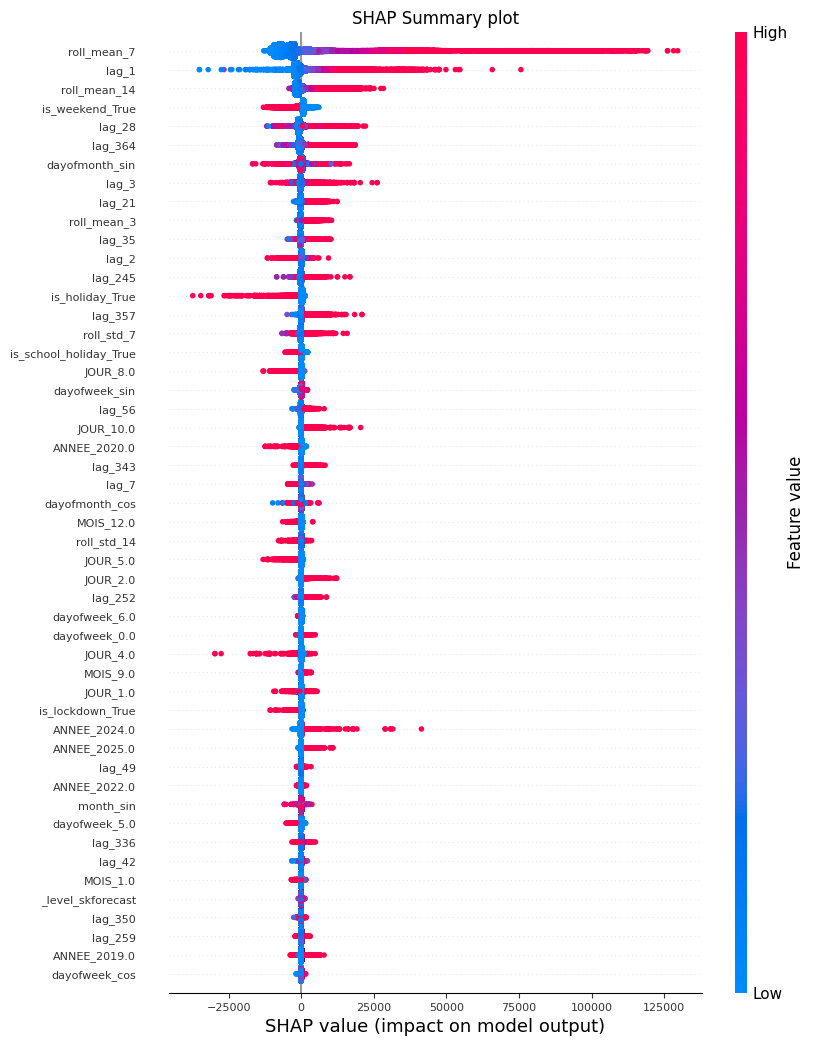

In [42]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=50, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(10, 10)

In [43]:
=============================================== en dessous exemple des etudiants de lannee derniere ======  
faut pas executer juste s'en inspirer

SyntaxError: unterminated string literal (detected at line 2) (396281353.py, line 2)

## Modele de Deep Leanring 

In [44]:
import sklearn
import keras 
import skforecast

print(f"keras version: {keras.__version__}")
print(f"XGBooskforecastst version: {skforecast.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

from skforecast.deep_learning import create_and_compile_model


os.environ["KERAS_BACKEND"] = "torch"  # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.plot import plot_prediction_intervals

keras version: 3.13.2
XGBooskforecastst version: 0.19.1
Scikit-learn version: 1.8.0


In [45]:
df_copy = df_copy.reset_index()

In [46]:
df_copy = df_copy.set_index(["DATE", "LIBELLE_ARRET"]).copy()
df_copy.head()

index  VALD_TOTAL  ANNEE  MOIS  JOUR  dayofweek  \
DATE       LIBELLE_ARRET                                                    
2015-01-01 ABLON              1         110   2015     1     1          3   
2015-01-02 ABLON            719         224   2015     1     2          4   
2015-01-03 ABLON           1440         231   2015     1     3          5   
2015-01-04 ABLON           2158         703   2015     1     4          6   
2015-01-05 ABLON           2880         219   2015     1     5          0   

                          is_holiday holiday_name  is_school_holiday  \
DATE       LIBELLE_ARRET                                               
2015-01-01 ABLON                True  1er janvier              False   
2015-01-02 ABLON               False          NaN              False   
2015-01-03 ABLON               False          NaN              False   
2015-01-04 ABLON               False          NaN              False   
2015-01-05 ABLON               False          NaN              False   

                          is_weekend  is_winter  is_spring  is_summer  \
DATE       LIBELLE_ARRET                                                
2015-01-01 ABLON               False       True      False      False   
2015-01-02 ABLON               False       True      False      False   
2015-01-03 ABLON                True       True      False      False   
2015-01-04 ABLON                True       True      False      False   
2015-01-05 ABLON               False       True      False      False   

                          is_autumn  is_lockdown  weekend_school_holiday  \
DATE       LIBELLE_ARRET                                                   
2015-01-01 ABLON              False        False                   False   
2015-01-02 ABLON              False        False                   False   
2015-01-03 ABLON              False        False                   False   
2015-01-04 ABLON              False        False                   False   
2015-01-05 ABLON              False        False                   False   

                          weekend_holiday  dayofweek_sin  dayofweek_cos  \
DATE       LIBELLE_ARRET                                                  
2015-01-01 ABLON                    False       0.433884      -0.900969   
2015-01-02 ABLON                    False      -0.433884      -0.900969   
2015-01-03 ABLON                    False      -0.974928      -0.222521   
2015-01-04 ABLON                    False      -0.781831       0.623490   
2015-01-05 ABLON                    False       0.000000       1.000000   

                          dayofmonth_sin  dayofmonth_cos  month_sin  month_cos  
DATE       LIBELLE_ARRET                                                        
2015-01-01 ABLON                0.000000        1.000000        0.5   0.866025  
2015-01-02 ABLON                0.201299        0.979530        0.5   0.866025  
2015-01-03 ABLON                0.394356        0.918958        0.5   0.866025  
2015-01-04 ABLON                0.571268        0.820763        0.5   0.866025  
2015-01-05 ABLON                0.724793        0.688967        0.5   0.866025

In [52]:
df_transfo =reshape_series_exog_dict_to_long(
    series= series_dict,
    exog=exog_dict
                                              )
df_transfo = df_transfo.reset_index()
df_transfo.tail(4)

series_id   datetime  series_value   ANNEE MOIS  JOUR dayofweek  \
204147    YERRES 2025-09-27        3250.0  2025.0  9.0  27.0       5.0   
204148    YERRES 2025-09-28        2335.0  2025.0  9.0  28.0       6.0   
204149    YERRES 2025-09-29        6456.0  2025.0  9.0  29.0       0.0   
204150    YERRES 2025-09-30        6752.0  2025.0  9.0  30.0       1.0   

        is_holiday  is_school_holiday  is_weekend  is_winter  is_spring  \
204147       False              False        True      False      False   
204148       False              False        True      False      False   
204149       False              False       False      False      False   
204150       False              False       False      False      False   

        is_summer  is_autumn  is_lockdown  weekend_school_holiday  \
204147      False       True        False                   False   
204148      False       True        False                   False   
204149      False       True        False                   False   
204150      False       True        False                   False   

        weekend_holiday  dayofweek_sin  dayofweek_cos  dayofmonth_sin  \
204147            False      -0.974928      -0.222521       -0.848644   
204148            False      -0.781831       0.623490       -0.724793   
204149            False       0.000000       1.000000       -0.571268   
204150            False       0.781831       0.623490       -0.394356   

        dayofmonth_cos  month_sin     month_cos  
204147        0.528964       -1.0 -1.836970e-16  
204148        0.688967       -1.0 -1.836970e-16  
204149        0.820763       -1.0 -1.836970e-16  
204150        0.918958       -1.0 -1.836970e-16

In [53]:
df_transfo = df_transfo.set_index("datetime")
df_transfo

series_id  series_value   ANNEE MOIS  JOUR dayofweek  is_holiday  \
datetime                                                                      
2015-01-01     ABLON         110.0  2015.0  1.0   1.0       3.0        True   
2015-01-02     ABLON         224.0  2015.0  1.0   2.0       4.0       False   
2015-01-03     ABLON         231.0  2015.0  1.0   3.0       5.0       False   
2015-01-04     ABLON         703.0  2015.0  1.0   4.0       6.0       False   
2015-01-05     ABLON         219.0  2015.0  1.0   5.0       0.0       False   
...              ...           ...     ...  ...   ...       ...         ...   
2025-09-26    YERRES        5641.0  2025.0  9.0  26.0       4.0       False   
2025-09-27    YERRES        3250.0  2025.0  9.0  27.0       5.0       False   
2025-09-28    YERRES        2335.0  2025.0  9.0  28.0       6.0       False   
2025-09-29    YERRES        6456.0  2025.0  9.0  29.0       0.0       False   
2025-09-30    YERRES        6752.0  2025.0  9.0  30.0       1.0       False   

            is_school_holiday  is_weekend  is_winter  is_spring  is_summer  \
datetime                                                                     
2015-01-01              False       False       True      False      False   
2015-01-02              False       False       True      False      False   
2015-01-03              False        True       True      False      False   
2015-01-04              False        True       True      False      False   
2015-01-05              False       False       True      False      False   
...                       ...         ...        ...        ...        ...   
2025-09-26              False       False      False      False      False   
2025-09-27              False        True      False      False      False   
2025-09-28              False        True      False      False      False   
2025-09-29              False       False      False      False      False   
2025-09-30              False       False      False      False      False   

            is_autumn  is_lockdown  weekend_school_holiday  weekend_holiday  \
datetime                                                                      
2015-01-01      False        False                   False            False   
2015-01-02      False        False                   False            False   
2015-01-03      False        False                   False            False   
2015-01-04      False        False                   False            False   
2015-01-05      False        False                   False            False   
...               ...          ...                     ...              ...   
2025-09-26       True        False                   False            False   
2025-09-27       True        False                   False            False   
2025-09-28       True        False                   False            False   
2025-09-29       True        False                   False            False   
2025-09-30       True        False                   False            False   

            dayofweek_sin  dayofweek_cos  dayofmonth_sin  dayofmonth_cos  \
datetime                                                                   
2015-01-01       0.433884      -0.900969        0.000000        1.000000   
2015-01-02      -0.433884      -0.900969        0.201299        0.979530   
2015-01-03      -0.974928      -0.222521        0.394356        0.918958   
2015-01-04      -0.781831       0.623490        0.571268        0.820763   
2015-01-05       0.000000       1.000000        0.724793        0.688967   
...                   ...            ...             ...             ...   
2025-09-26      -0.433884      -0.900969       -0.937752        0.347305   
2025-09-27      -0.974928      -0.222521       -0.848644        0.528964   
2025-09-28      -0.781831       0.623490       -0.724793        0.688967   
2025-09-29       0.000000       1.000000       -0.571268        0.820763   
2025-09-30       0.781831   

In [56]:
df_transfo = df_transfo.sort_index()

In [73]:
end_train = "2025-08-31"

data_train = df_transfo.loc[:end_train].copy()
data_test  = df_transfo.loc[end_train:].copy()


print(
    f"Dates train      : {data_train.index.min()} --- " 
    f"{data_train.index.max()}  (n={len(data_train)})"
)

print(
    f"Dates test       : {data_test.index.min()} --- " 
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Dates train      : 2015-01-01 00:00:00 --- 2025-08-31 00:00:00  (n=202591)
Dates test       : 2025-08-31 00:00:00 --- 2025-09-30 00:00:00  (n=1612)


In [63]:
data_train = data_train.reset_index()

models = {}
forecasters = {}

for gare, df_gare in data_train.groupby("series_id"):

    # Trier et mettre l'index en DatetimeIndex
    df_gare = df_gare.sort_values("datetime").set_index("datetime")

    # Séparer target et exog
    series = df_gare[["series_value"]]
    exog   = df_gare.drop(columns=["series_id", "series_value"])

    # Forcer la fréquence journalière
    series = series.asfreq("D")
    exog   = exog.asfreq("D")
    series["series_value"] = series["series_value"].ffill()

    # Créer le modèle
    model = create_and_compile_model(
        series                    = series,
        levels                    = ["series_value"],
        lags                      = 30,
        steps                     = 30,
        exog                      = exog,
        recurrent_layer           = "LSTM",
        recurrent_units           = [128, 64],
        recurrent_layers_kwargs   = [{'activation': 'tanh'}, {'activation': 'relu'}],
        dense_units               = [128, 64],
        dense_layers_kwargs       = {'activation': 'relu'},
        output_dense_layer_kwargs = {'activation': 'linear'},
        compile_kwargs            = {'optimizer': Adam(), 'loss': MeanSquaredError()},
    )

    # Créer le forecaster
    forecaster = ForecasterRnn(
        estimator=model,
        levels=["series_value"],
        lags=30,
        fit_kwargs={
            "epochs": 2,
            "batch_size": 1024,
            "callbacks": [
                EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=2,
                    min_lr=1e-5,
                    verbose=1
                )
            ]
        }
    )

    # Entraîner le forecaster
    forecaster.fit(series=series, exog=exog, suppress_warnings= True)

    # Stocker le modèle et forecaster
    models[gare] = model
    forecasters[gare] = forecaster

print("✅ Modèles entraînés pour toutes les gares :", list(models.keys()))


keras version: 3.13.2
Using backend: tensorflow
tensorflow version: 2.18.1

Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - loss: 0.0908 - learning_rate: 0.0010
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - loss: 0.0829 - learning_rate: 0.0010
keras version: 3.13.2
Using backend: tensorflow
tensorflow version: 2.18.1

Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - loss: 0.1279 - learning_rate: 0.0010
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - loss: 0.1443 - learning_rate: 0.0010
keras version: 3.13.2
Using backend: tensorflow
tensorflow version: 2.18.1

Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - loss: 0.0893 - learning_rate: 0.0010
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 0.0894 - learning_rate: 0.0010
keras version: 3.13.2
Using backend: tensorflow
tensorflow version: 2.18.1

Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - loss: 0.1613 - learning_rate: 0.0010
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - loss: 0.1457 - learning_rate:

In [83]:
forecasters["ABLON"]

KeyError: 'ABLON'

In [87]:
list(models.keys())

[]

In [81]:
forecaster

============= 
ForecasterRnn 
============= 
Estimator: <Functional name=functional_105, built=True> 
Layers names: ['series_input', 'lstm_1', 'lstm_2', 'repeat_vector', 'exog_input', 'concat_exog', 'dense_td_1', 'dense_td_2', 'output_dense_td_layer'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Maximum steps to predict: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Series names: series_value 
Target series (levels): ['series_value'] 
Exogenous included: True 
Exogenous names: 
    level_0, index, ANNEE, MOIS, JOUR, dayofweek, is_holiday, is_school_holiday,
    is_weekend, is_winter, is_spring, is_summer, is_autumn, is_lockdown,
    weekend_school_holiday, weekend_holiday, dayofweek_sin, dayofweek_cos,
    dayofmonth_sin, dayofmonth_cos, month_sin, month_cos 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: [Timestamp('2015-01-01 00:00:00'), Timestamp('2025-08-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: {'name': 'functional_105', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 30, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input', 'optional': False}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 1]}, 'name': 'lstm_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 30, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 

In [77]:
print("Nb lignes df_transfo :", len(df_transfo))
print("Nb gares :", df_transfo["series_id"].nunique())
print(df_transfo["series_id"].value_counts().head())


Nb lignes df_transfo : 204151
Nb gares : 52
series_id
ABLON             3926
NOISIEL           3926
ETAMPES           3926
GAMBETTA          3926
CHATOU-CROISSY    3926
Name: count, dtype: int64


In [74]:
data_test.columns


Index(['series_id', 'series_value', 'ANNEE', 'MOIS', 'JOUR', 'dayofweek',
       'is_holiday', 'is_school_holiday', 'is_weekend', 'is_winter',
       'is_spring', 'is_summer', 'is_autumn', 'is_lockdown',
       'weekend_school_holiday', 'weekend_holiday', 'dayofweek_sin',
       'dayofweek_cos', 'dayofmonth_sin', 'dayofmonth_cos', 'month_sin',
       'month_cos'],
      dtype='object')

In [78]:
predictions_all = {}

data_test = data_test.copy()

for gare, df_gare in data_test.groupby("series_id"):

    print(f"🔮 Prédiction pour la gare : {gare}")

    forecaster_gare = forecasters[gare]

    df_gare = df_gare.sort_values("datetime").set_index("datetime")

    series = df_gare[["series_value"]]
    exog   = df_gare.drop(columns=["series_id", "series_value"])

    series = series.resample("D").sum()
    exog   = exog.resample("D").first()

    series = series.asfreq("D")
    exog   = exog.asfreq("D")

    series["series_value"] = series["series_value"].ffill()
    exog = exog.ffill()

    preds = forecaster_gare.predict(exog=exog)

    predictions_all[gare] = preds


🔮 Prédiction pour la gare : ABLON


KeyError: 'ABLON'

In [76]:
print(forecasters.keys())

dict_keys([])


In [ ]:
# Prediction with exogenous variables
# ==============================================================================
predictions = forecaster.predict(exog=[exog_features])
predictions.head(4)
